In [3]:
from scipy.fftpack import dct, idct
import numpy as np
import cv2
from PIL import Image
from glob import glob
import os
from pyiqa import create_metric
import pyiqa
from tqdm import tqdm
import csv
from PIL import Image
import os
import pandas as pd
from pathlib import Path
import sys
sys.path.append('../code/')
from utils import calculate_correctness

import seaborn as sns
import matplotlib.pyplot as plt

/home/jcardenuto/miniconda3/envs/iqa/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# Evaluated metrics
model_names = {
    "TOPIQ": ["topiq_nr", "topiq_nr-flive", "topiq_nr-spaq"],
    "TReS": ["tres", "tres-koniq", "tres-flive"],
    "FID": ["fid"],
    "CLIPIQA(+)": ["clipiqa", "clipiqa+", "clipiqa+_vitL14_512", "clipiqa+_rn50_512"],
    "MANIQA": ["maniqa", "maniqa-kadid", "maniqa-koniq", "maniqa-pipal"],
    "MUSIQ": ["musiq", "musiq-koniq", "musiq-spaq", "musiq-paq2piq", "musiq-ava"],
    "DBCNN": ["dbcnn"],
    "PaQ-2-PiQ": ["paq2piq"],
    "HyperIQA": ["hyperiqa"],
    "NIMA": ["nima", "nima-vgg16-ava"],
    "WaDIQaM": [],
    "CNNIQA": ["cnniqa"],
    "NRQM(Ma)2": ["nrqm"],
    "PI(Perceptual Index)": ["pi"],
    "BRISQUE": ["brisque"],
    "ILNIQE": ["ilniqe"],
    "NIQE": ["niqe"]
}


In [4]:
iqa_df = pd.read_csv("../results/iqa_results_with_arrows.csv")

In [5]:
correctness_df = calculate_correctness(iqa_df)

In [6]:
correctness_df = correctness_df.rename(columns={'labeled_quality': "Quality", 'pred_compression ↓': "Compression ↓", 'pred_pixelation ↓': "Pixelation ↓"})
correctness_df = correctness_df.rename(columns={x: x.replace(" ↓", "") for x in correctness_df.columns})
correctness_df = correctness_df.rename(columns={x: x.replace(" ↑", "") for x in correctness_df.columns})

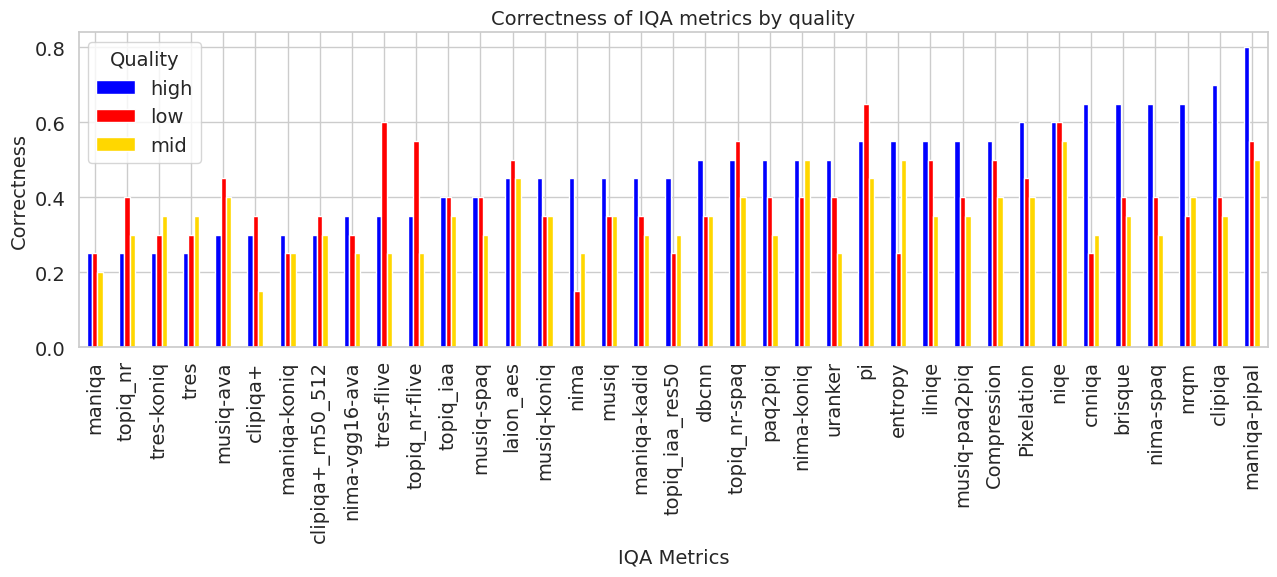

In [7]:
# Plot the correctness of the metrics
# sns settings
fontsize =14
sns.set(rc={'figure.figsize':(20, 5), 'font.size':fontsize, 'axes.titlesize':fontsize, 'axes.labelsize':fontsize, 'xtick.labelsize':fontsize, 'ytick.labelsize':fontsize, 'legend.fontsize':fontsize, 'legend.title_fontsize':fontsize})
sns.set_style('whitegrid')
# include a black edge in the bars
# sns.set_context("paper", rc={"lines.linewidth": 2.5})

# make high quality blue, mid yellow and low red
colors = {'high': 'blue', 'mid': 'gold', 'low': 'red'}
correctness_df.groupby("Quality").mean().T.sort_values("high", ascending=True).plot(kind="bar", figsize=(13, 6), title="Correctness of IQA metrics by quality", 
                                color=[colors[x] for x in correctness_df.groupby("Quality").mean().T.columns],
                                xlabel="IQA Metrics", ylabel="Correctness")
# change name of the legend to Quality
plt.legend(title="Quality", loc="upper left")
plt.tight_layout()
plt.savefig("../results/percentile/iqa_correctness.pdf", dpi=100)

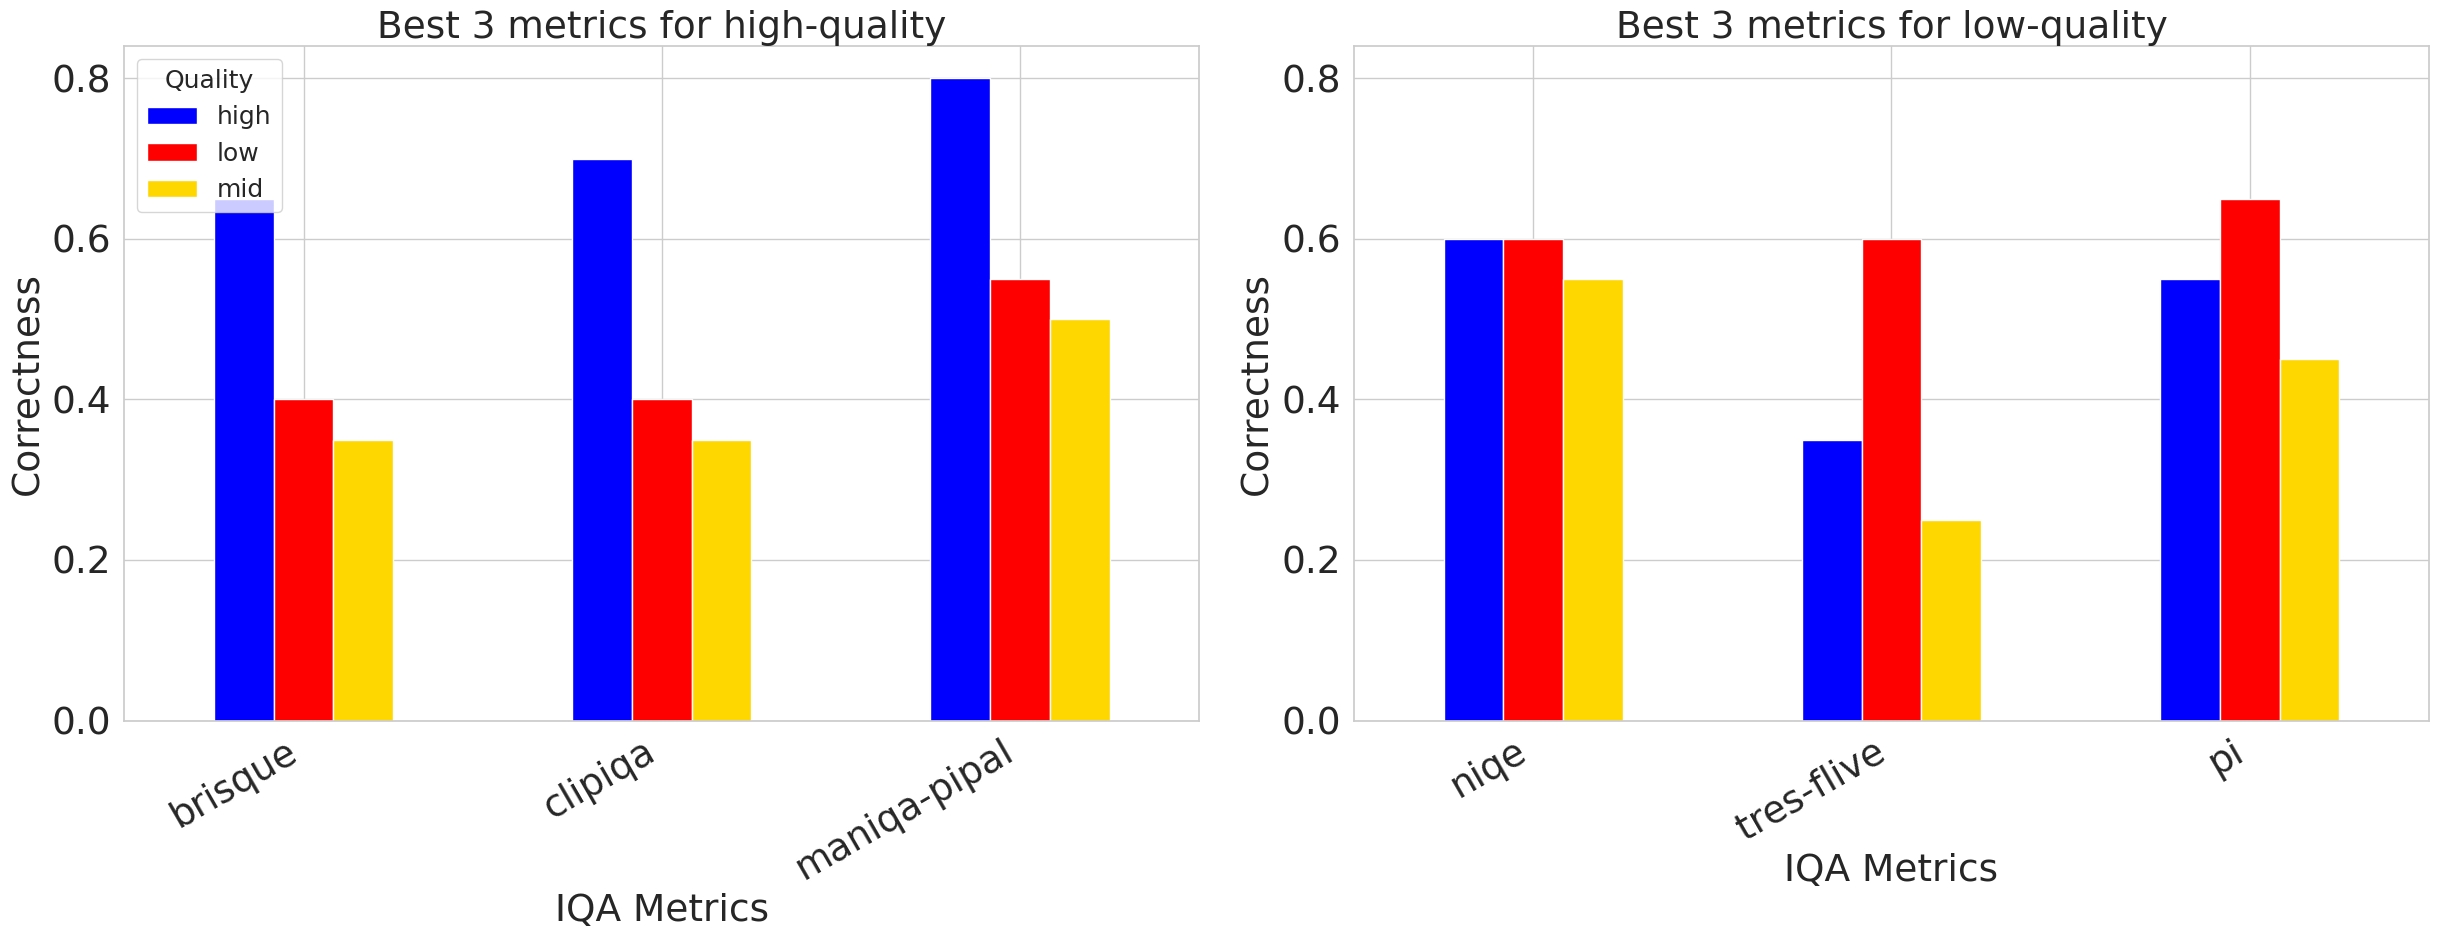

In [7]:
# sns settings
fontsize=27
sns.set(rc={'figure.figsize':(15, 10), 'font.size':fontsize, 'axes.titlesize':fontsize, 'axes.labelsize':fontsize, 'xtick.labelsize':fontsize, 'ytick.labelsize':fontsize, 'legend.fontsize':fontsize, 'legend.title_fontsize':fontsize})
sns.set_style('whitegrid')
# include a black edge in the bars
# sns.set_context("paper", rc={"lines.linewidth": 2.5})

# make high quality blue, mid yellow and low red
colors = {'high': 'blue', 'mid': 'gold', 'low': 'red'}

fig, ax = plt.subplots(1, 2, figsize=(25, 10))

# print best 3 best models for each quality
correctness_df.groupby("Quality").mean().T.nlargest(3, "high").sort_values("high", ascending=True).plot(kind="bar", ax=ax[0], title="Best 3 metrics for high-quality", 
                                color=[colors[x] for x in correctness_df.groupby("Quality").mean().T.columns],
                                xlabel="IQA Metrics", ylabel="Correctness",
                                )
ax[0].legend(title="Quality", loc="upper left", fontsize=18, title_fontsize=18)
ax[0].set_xticklabels(ax[0].get_xticklabels(), rotation=30, horizontalalignment='right')

correctness_df.groupby("Quality").mean().T.nlargest(3, "low").sort_values("low", ascending=True).plot(kind="bar", ax=ax[1], title="Best 3 metrics for low-quality", 
                                 color=[colors[x] for x in correctness_df.groupby("Quality").mean().T.columns],
                                 xlabel="IQA Metrics", ylabel="Correctness")
ax[1].set_ylim(ax[0].get_ylim())
ax[1].legend().remove()
ax[1].set_xticklabels(ax[1].get_xticklabels(), rotation=30, horizontalalignment='right')

plt.tight_layout()
plt.savefig("../results/percentile/best-results-iqa.pdf", dpi=100)

In [8]:
from sklearn.metrics import roc_curve

def get_best_threshold(model, plot=False):
    low = iqa_df_n[iqa_df_n["labeled_quality"] == "low"]
    high = iqa_df_n[iqa_df_n["labeled_quality"] == "high"]
    data = pd.concat([low, high], ignore_index=True)
    # make low quality as 0
    data["labeled_quality"] = data["labeled_quality"].apply(lambda x: 0 if x == "low" else 1)
    labels = data["labeled_quality"].values.tolist()
    y = data[model].values.tolist()
    if '↓' in model:
        y = [-x for x in y]
    # Calculate ROC curve
    fpr, tpr, thresholds = roc_curve(labels, y)

    # Find the optimal threshold (maximizing tpr - fpr)
    optimal_idx = np.argmax(tpr - fpr)
    optimal_threshold = thresholds[optimal_idx]
    if plot:
        # Plot ROC curve
        plt.plot(fpr, tpr)
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title('ROC Curve')
        plt.show()
    if '↓' in model:
        optimal_threshold = -optimal_threshold
    return optimal_threshold


In [9]:
iqa_df = pd.read_csv("../results/iqa_results_with_arrows.csv")
correctness_df = calculate_correctness(iqa_df)
iqa_df = iqa_df.rename(columns={'labeled_quality': "Quality", 'pred_compression ↓': "Compression ↓", 'pred_pixelation ↓': "Pixelation ↓"})
correctness_df = correctness_df.rename(columns={'labeled_quality': "Quality", 'pred_compression ↓': "Compression ↓", 'pred_pixelation ↓': "Pixelation ↓"})
# iqa_df = iqa_df.rename(columns={x: x.replace(" ↓", "") for x in iqa_df.columns})
# iqa_df = iqa_df.rename(columns={x: x.replace(" ↑", "") for x in iqa_df.columns})
iqa_df["labeled_quality"] = iqa_df["Quality"]

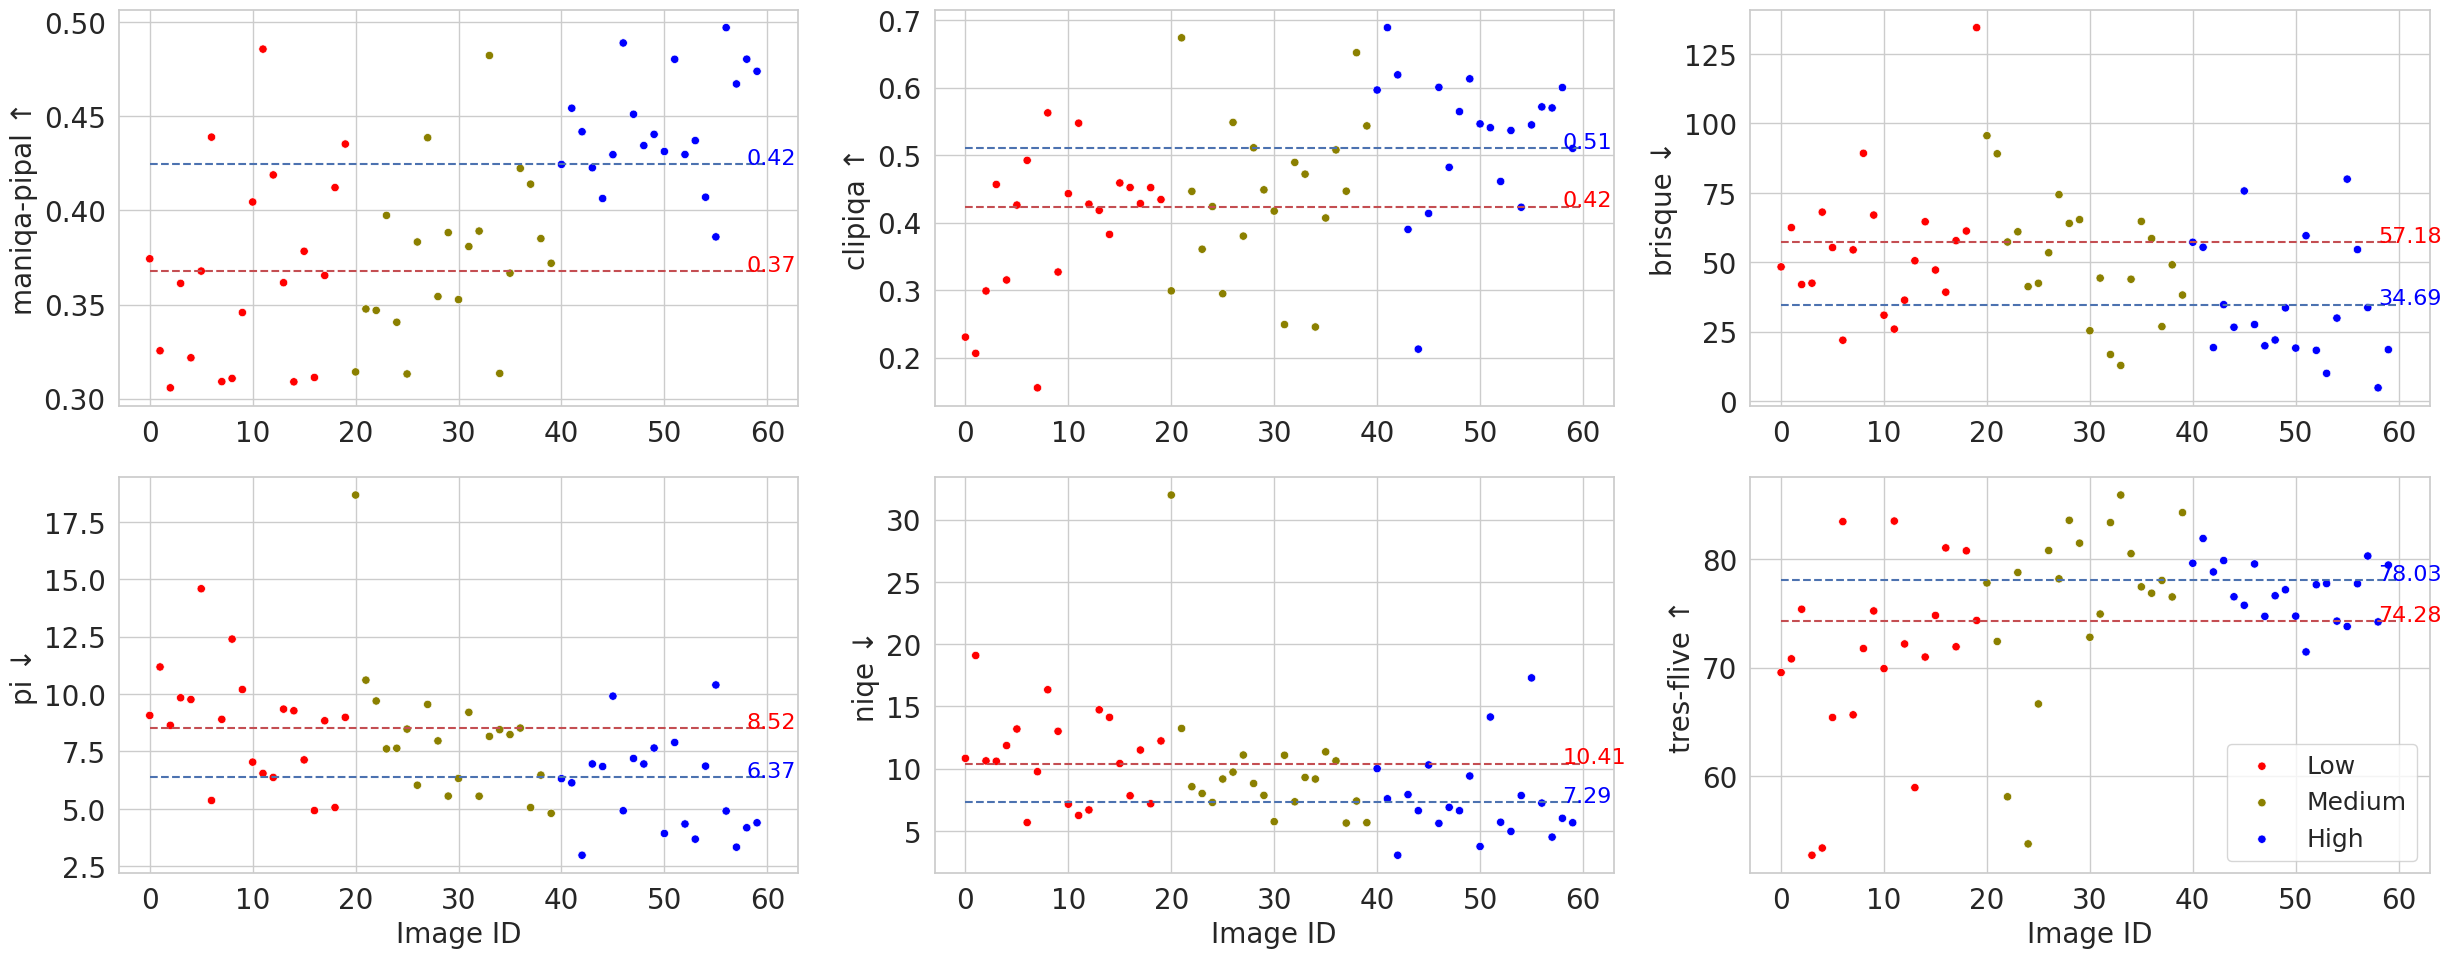

In [13]:
# plot the score of each best model painted by its quality label
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(rc={'figure.figsize':(20, 10), 'font.size':20, 'axes.titlesize':20, 'axes.labelsize':20, 'xtick.labelsize':20, 'ytick.labelsize':20, 'legend.fontsize':18, 'legend.title_fontsize':20})
sns.set_style('whitegrid')
low = iqa_df[iqa_df["Quality"] == "low"]
mid = iqa_df[iqa_df["Quality"] == "mid"]
high = iqa_df[iqa_df["Quality"] == "high"]
iqa_df = pd.concat([low, mid, high], ignore_index=True)

low = correctness_df[correctness_df["Quality"] == "low"]
mid = correctness_df[correctness_df["Quality"] == "mid"]
high = correctness_df[correctness_df["Quality"] == "high"]
correctness_df = pd.concat([low, mid, high], ignore_index=True)

colors = {'high': 'blue', 'mid': '#8B8000', 'low': 'red'}
fig, ax = plt.subplots(nrows=2, ncols=3, figsize=(25, 10))

for qi, quality in enumerate(["high", "low"]):
# plot the score of the best 3 models for each Quality
    for i, model in enumerate(correctness_df.groupby("Quality").mean().T.nlargest(3, quality).index):
        model_scores = iqa_df[[model]]
        normalized_model_scores = (model_scores - model_scores.min()) / (model_scores.max() - model_scores.min())
        iqa_df_n = iqa_df.copy()

        # Normalize the scores
        # normalized_model_scores = normalized_model_scores * 100
        # iqa_df_n[model] = normalized_model_scores
        # model_scores = normalized_model_scores

        
        threshold = get_best_threshold(model)
        # Remove arrows from the plot
        # model = model.replace(" ↓", "")
        # model = model.replace(" ↑", "")
        # plot low quality in red, mid in yellow and high in blue

        label=""
        if i==2 and qi == 1:
            label="Low"
        sns.scatterplot(data=model_scores[:20], x=model_scores.index[:20], y=model, color=[colors[x] for x in correctness_df["Quality"][:20]], ax=ax[qi, i],
                        label=label)
        label=""
        if i==2 and qi == 1:
            label="Medium"
        sns.scatterplot(data=model_scores[20:40], x=model_scores.index[20:40], y=model, color=[colors[x] for x in correctness_df["Quality"][20:40]], ax=ax[qi, i],
                        label=label,)
        label=""
        if i==2 and qi == 1:
            label="High"
        sns.scatterplot(data=model_scores[40:], x=model_scores.index[40:], y=model, color=[colors[x] for x in correctness_df["Quality"][40:]], ax=ax[qi, i],
                        label=label)
        
        # include legend
        if qi == 1:
            ax[qi, i].set_xlabel(f"Image ID")
        else:
            ax[qi, i].set_xlabel("")
        # plot the mean of the model for each Quality
        high_mean = model_scores.quantile([0.666], interpolation="nearest").values[0][0]
        low_mean = model_scores.quantile([0.333], interpolation="nearest").values[0][0]

        # blot text with the mean of the model for each quality
        # ax[qi, i].plot([0, len(model_scores)], [threshold, threshold], 'b--')
        # ax[qi, i].text(58, threshold, f"{threshold:.2f}", fontsize=16, color="blue")
        if "↑" in model:
            ax[qi, i].plot([0, len(model_scores)], [high_mean, high_mean], 'b--')
            ax[qi, i].text(58, high_mean, f"{high_mean:.2f}", fontsize=16, color="blue")

            ax[qi, i].plot([0, len(model_scores)], [low_mean, low_mean], 'r--')
            ax[qi, i].text(58, low_mean, f"{low_mean:.2f}", fontsize=16, color="red")

        else:
            ax[qi, i].plot([0, len(model_scores)], [high_mean, high_mean], 'r--')
            ax[qi, i].text(58, high_mean, f"{high_mean:.2f}", fontsize=16, color="red")

            ax[qi, i].plot([0, len(model_scores)], [low_mean, low_mean], 'b--')
            ax[qi, i].text(58, low_mean, f"{low_mean:.2f}", fontsize=16, color="blue")

plt.tight_layout()
plt.savefig("../results/percentile/best_iqa_scores_percentile_visualization.pdf", dpi=100)

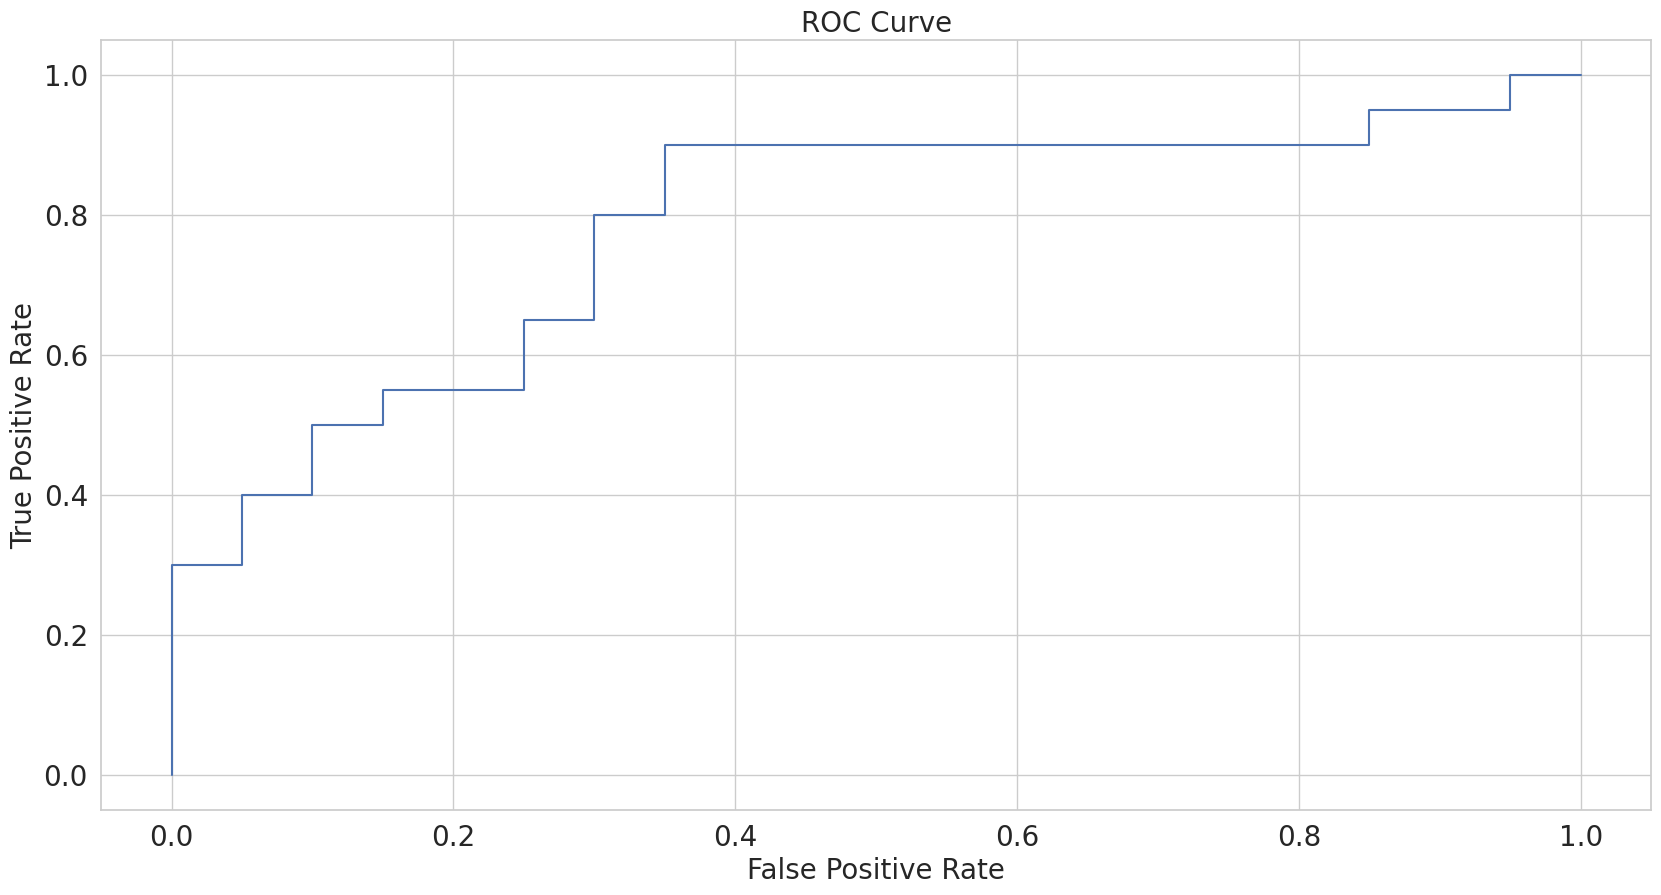

10.298768397313596

In [18]:
import matplotlib.pyplot as plt
get_best_threshold("niqe ↓", plot=True)

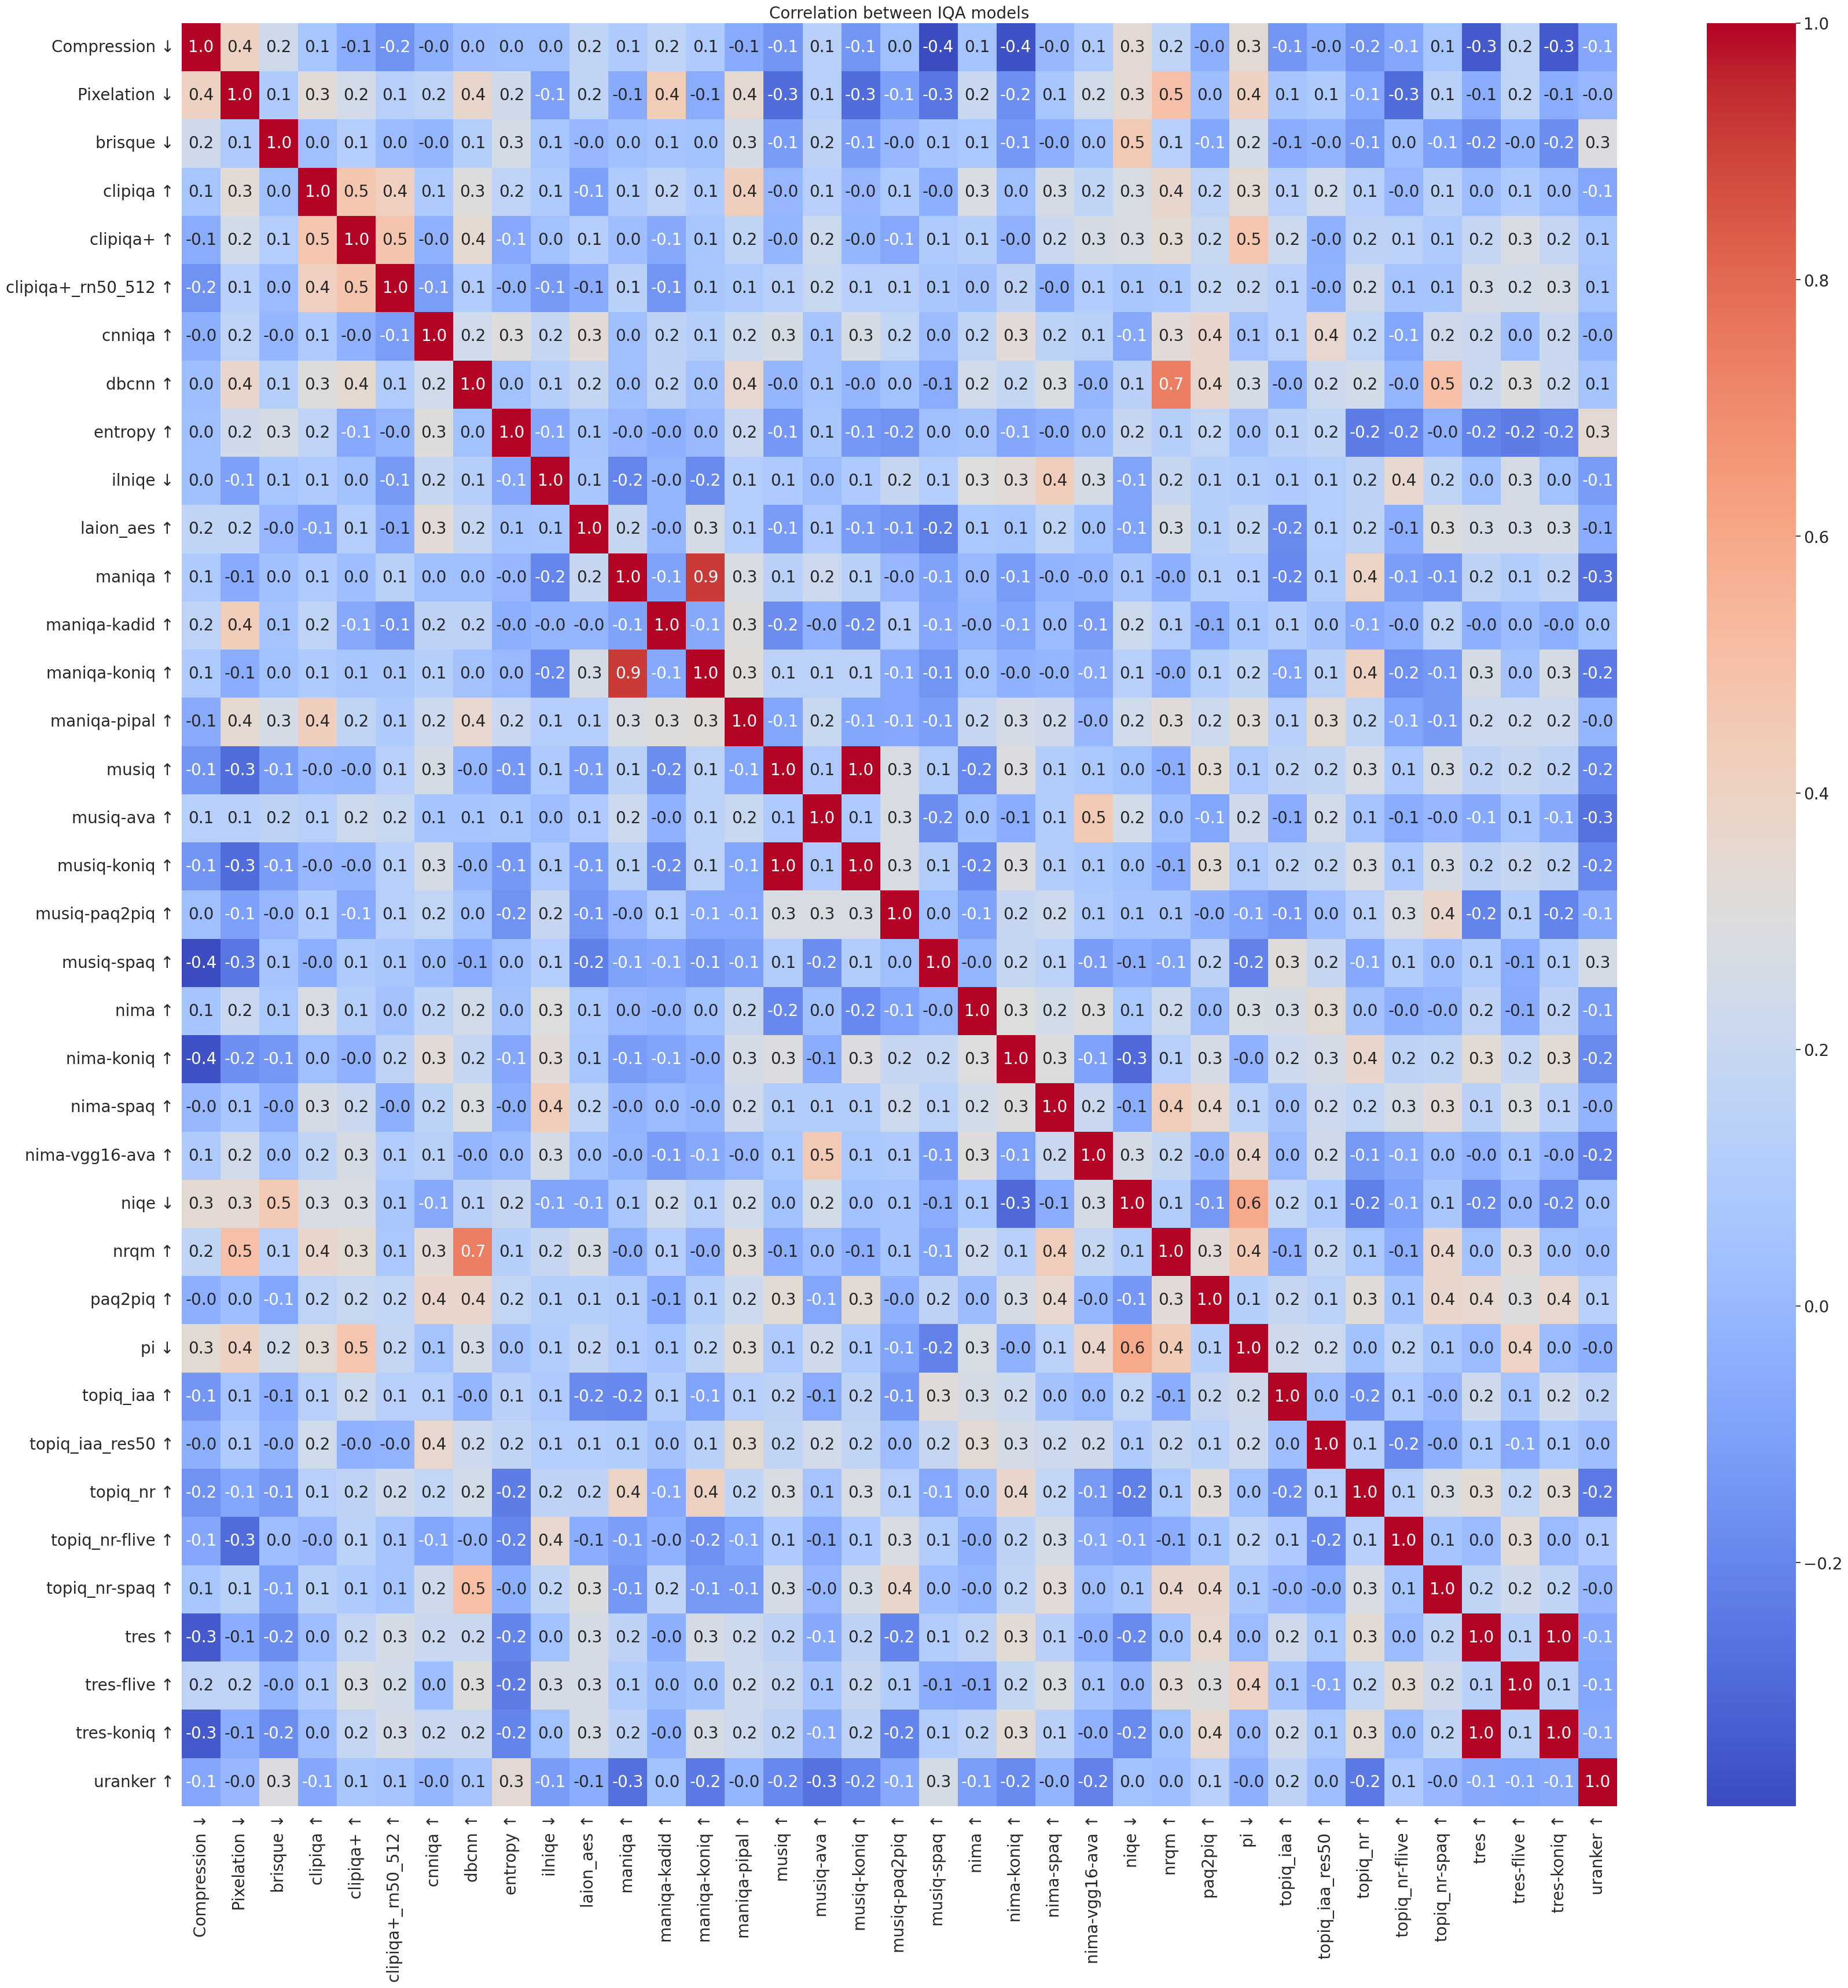

In [21]:
# plot the correlation between the scores
import seaborn as sns
import matplotlib.pyplot as plt
# correlation_df = correlation_df[scores_names]
df = correctness_df.drop("Quality", axis=1)
correlation = df.corr()
plt.figure(figsize=(40, 40))
sns.heatmap(correlation, annot=True, cmap="coolwarm", fmt=".1f")
plt.title("Correlation between IQA models")
plt.show()

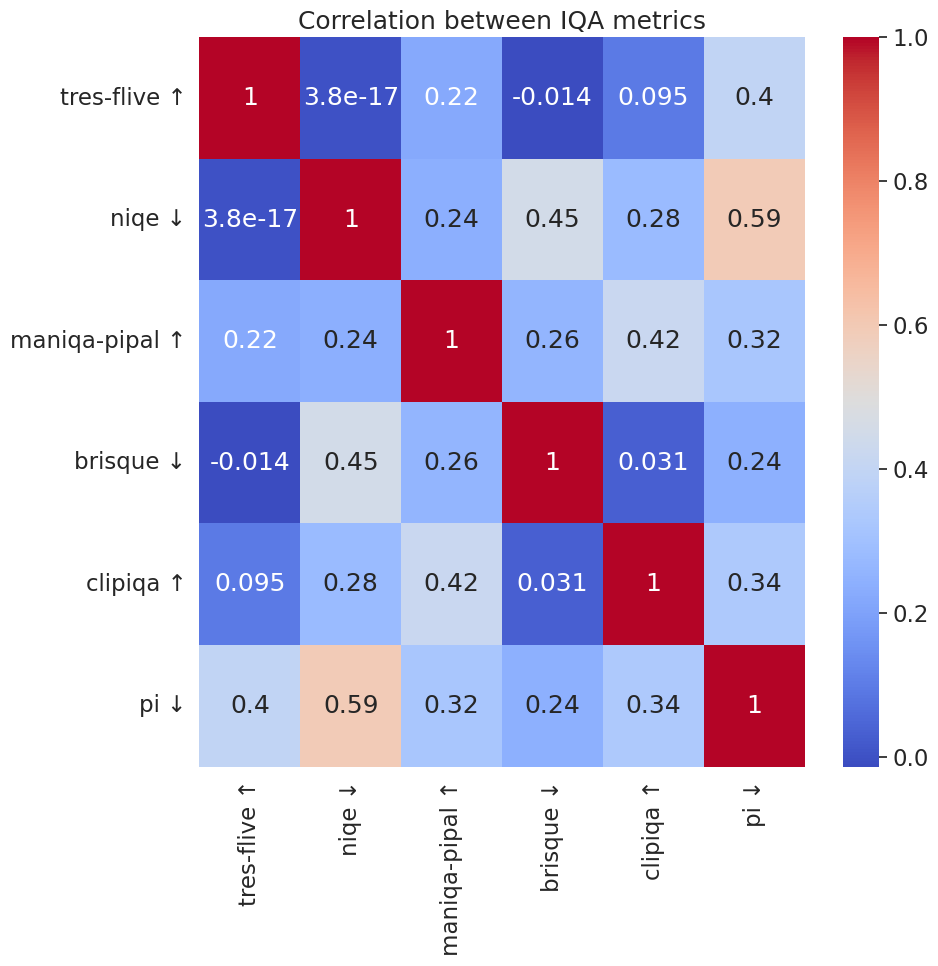

In [23]:
# plot the correlation between the scores
import seaborn as sns
import matplotlib.pyplot as plt
scores_names = []
scores_names += correctness_df.groupby("Quality").mean().T.nlargest(3, "high").index.tolist()
scores_names += correctness_df.groupby("Quality").mean().T.nlargest(3, "low").index.tolist()
scores_names = list(set(scores_names))
df = correctness_df[scores_names]
correlation = df.corr()
plt.figure(figsize=(10, 10))
# increase font
sns.set(font_scale=1.5)
sns.heatmap(correlation, annot=True, cmap="coolwarm")
plt.title("Correlation between IQA metrics")
plt.tight_layout()
plt.savefig("../results/percentile/correlation_iqa.pdf", dpi=100)
plt.show()